In [1]:
import sys
import torch
import os
from os import makedirs
from argparse import ArgumentParser
from argparse import Namespace
from arguments import ModelParams, PipelineParams, OptimizationParams, get_combined_args
import numpy as np
from scene import Scene, GaussianModel
from utils.general_utils import safe_state
import open3d as o3d
from random import randint
from gaussian_renderer import render, network_gui
import matplotlib.pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Setup Command line Arg
sys.argv = ["train.py", "-s", "G:\\Universitat Siegen\\SA\\P-GPU\\Code\\gaussian-splatting\\data\\RGBD_Data"]
                        # "-m" , "G:\\Universitat Siegen\\SA\\P-GPU\\Code\\gaussian-splatting\\output\\RGBD_Model"]

parser = ArgumentParser(description='Progressice Gaussian Splatting')
model = ModelParams(parser)
pipeline = PipelineParams(parser)
op = OptimizationParams(parser)

# parser.add_argument('--ip', type=str, default="127.0.0.1")
# parser.add_argument('--port', type=int, default=6009)
# parser.add_argument('--debug_from', type=int, default=-1)
# parser.add_argument('--detect_anomaly', action='store_true', default=False)
# parser.add_argument("--save_iterations", nargs="+", type=int, default=3000)
# parser.add_argument("--test_iterations", nargs="+", type=int, default=3000)
parser.add_argument("--quiet", action="store_true")
# parser.add_argument("--checkpoint_iterations", nargs="+", type=int, default=3000)
# parser.add_argument("--start_checkpoint", type=str, default = None)

args = parser.parse_args(sys.argv[1:])

# Initialize system state (RNG)
safe_state(args.quiet)

dataset, iteration, pipeline = model.extract(args), op.extract(args), pipeline.extract(args)

In [3]:
with torch.no_grad():
    # Initialize Gaussians with Zero Tensor
    gaussians = GaussianModel(dataset.sh_degree)

    # Load Actual Gaussians, Camera from PCD
    scene = Scene(dataset, gaussians, shuffle=False)

Loading RGBD Scene [05/11 16:48:29]
Loading Training Cameras [05/11 16:48:30]
[ INFO ] Encountered quite large input images (>1.6K pixels width), rescaling to 1.6K.
 If this is not desired, please explicitly specify '--resolution/-r' as 1 [05/11 16:48:30]
Loading Test Cameras [05/11 16:49:36]
Number of points at initialisation :  1708432 [05/11 16:49:37]


In [14]:
# Pick a random Camera
viewpoint_stack = None
opt = op.extract(args)
if not viewpoint_stack:
    viewpoint_stack = scene.getTrainCameras().copy()


# viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))
viewpoint_cam = viewpoint_stack[0]
# Render
bg = torch.rand((3), device="cuda")

render_pkg = render(viewpoint_cam, gaussians, pipeline, bg)

image, viewspace_point_tensor, visibility_filter, radii = render_pkg["render"], render_pkg["viewspace_points"], render_pkg["visibility_filter"], render_pkg["radii"]


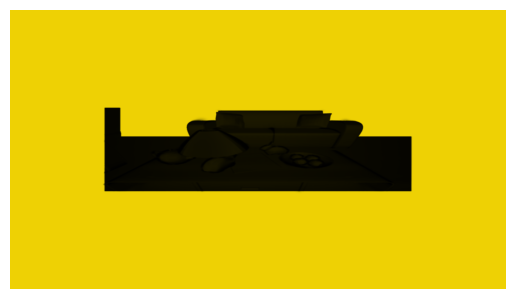

In [15]:
image_numpy = image.cpu().detach().numpy()

# Transpose the dimensions to [height, width, channels]
image_numpy = np.transpose(image_numpy, (1, 2, 0))

# Display the image using Matplotlib
plt.imshow(image_numpy)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()